In [275]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, ElasticNet, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from prettytable import PrettyTable

# Part 1

In [301]:
bike_df = pd.read_csv('bike_share_hour.csv')

In [302]:
bike_df.sample(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
15385,15386,2012-10-08,4,1,10,6,1,1,0,1,0.34,0.3485,0.76,0.1045,5,54,59
584,585,2011-01-26,1,0,1,15,0,3,1,3,0.22,0.1818,0.93,0.4627,1,42,43
3116,3117,2011-05-14,2,0,5,18,0,6,0,2,0.56,0.5303,0.88,0.2239,88,216,304


#### Initial Look at types

In [173]:
bike_df.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

#### Transform Categoricals

In [303]:
bike_df[['season', 'holiday', 'weekday', 'workingday', 'weathersit']] = bike_df[['season', 'holiday', 'weekday', 'workingday', 'weathersit']].astype('category')

#### After look

In [175]:
bike_df.dtypes

instant          int64
dteday          object
season        category
yr               int64
mnth             int64
hr               int64
holiday       category
weekday       category
workingday    category
weathersit    category
temp           float64
atemp          float64
hum            float64
windspeed      float64
casual           int64
registered       int64
cnt              int64
dtype: object

#### Nulls - There appears to be none.  

In [176]:
bike_df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

#### Built-in Describe for a quick look into the dataframe

In [177]:
bike_df.describe()

,instant,yr,mnth,hr,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,0.502561,6.537775,11.546752,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,0.500008,3.438776,6.914405,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,0.000000,1.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,0.000000,4.000000,6.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,1.000000,7.000000,12.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,1.000000,10.000000,18.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,1.000000,12.000000,23.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


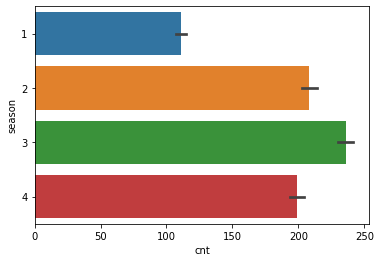

In [178]:
sns.barplot(x='cnt', y='season', data=bike_df);

It appears fall (3) has the most bike rides and spring (1) has the least bike rides.  

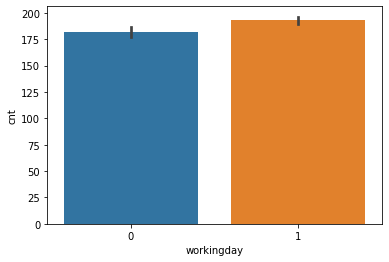

In [179]:
sns.barplot(x='workingday', y='cnt', data=bike_df);

At first it appears there is a surprisingly small difference between the count of bike rides on working days vs non-working days.  But there are significantly more working days than there are non-working days.  Day of the week may give us a better look at the distribution.  But will take some looking into.    

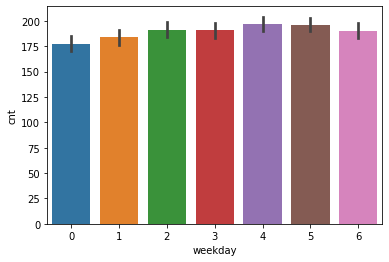

In [180]:
sns.barplot(x='weekday', y='cnt', data=bike_df);

Unfortunately the distribution of rides against the day of the week has only created more questions.  We may need to revisit this as I would not have expected this behavior.

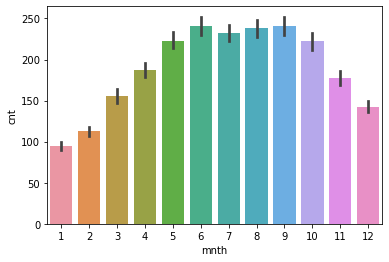

In [181]:
sns.barplot(x='mnth', y='cnt', data=bike_df);

The distribution of rides against month appears to be normal.  But we can figure out the season the month is in just to be sure.  

In [182]:
group = bike_df.groupby('season')
group = group.apply(lambda x: x['mnth'].unique())
group

season
1      [1, 2, 3, 12]
2       [3, 4, 5, 6]
3       [6, 7, 8, 9]
4    [9, 10, 11, 12]
dtype: object

It appears we cannot trust 1 as January and 12 as December. 12 may be March? Interesting distribution with the overlap of seasons as well, that may be something of note.  

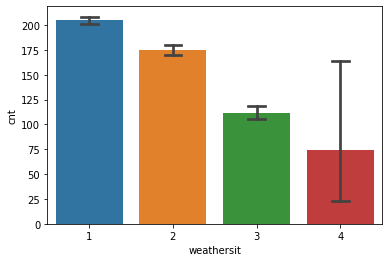

In [183]:
sns.barplot(x='weathersit', y='cnt', data=bike_df, capsize=.2);

Weather situation 4 has the least bike rentals.  It appears heavy rain, ice pallets, thunderstorms, mist, snow, and fog discourage biking.  But the error bar is quite large.  That may warrant some investigation.

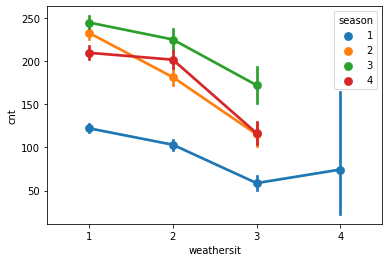

In [306]:
sns.pointplot(x='weathersit', y='cnt', hue='season', data=bike_df);

It appears season 1 (spring) is the only season with the worst performing weather situation.  That may explain why spring is the least biked, but that will require further analysis.  

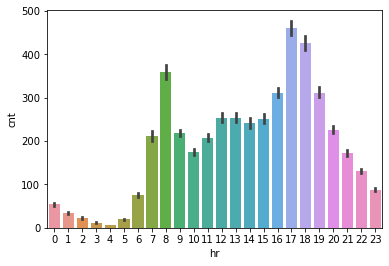

In [307]:
sns.barplot(x='hr', y='cnt', data=bike_df);

If we can assume the hour measure is parrallel to the 24 hour cycle and 0 is the 0 hour and 23 is day end, then most bike rides occur in the evening, but a noticable amount occure in the morning.  But the timming assumption may be rather bold as the month assumption doesn't appear to hold with our data.

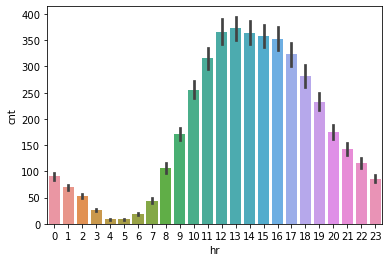

In [308]:
sns.barplot(x='hr', y='cnt', data=bike_df[bike_df['workingday'] == 0]);

I am less confident on our assumption of the 24 hour cycle parallel because of the proportion of people that woule be biking between midnight and 3 am.  But I don't know if we will be able to make a determination on that.  Or if it is even worth it to look into further. That said, there is a noticeable change in behvior on non owrkingdays.  There is a lot more biking around lunch time.  It may be influenced more by availability of light rather than free time.  But that is likely going beyong the current analysis objective.  

# Part 2

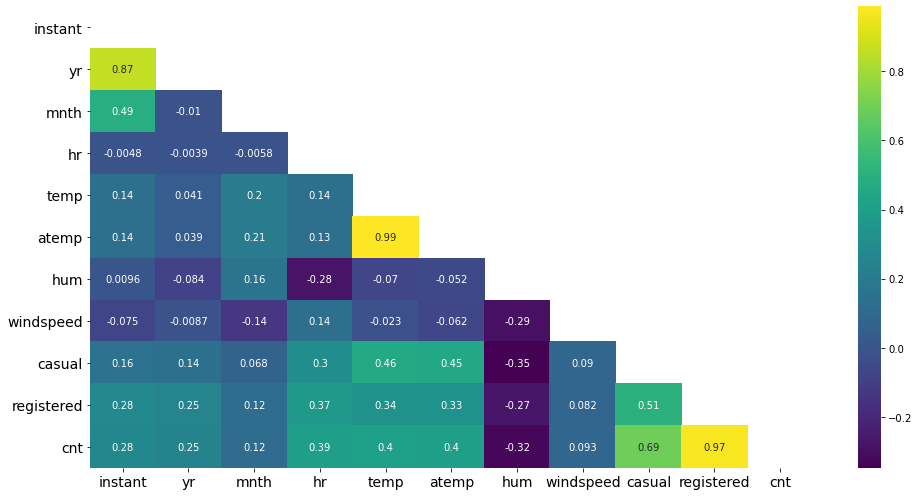

In [187]:
fig, ax = plt.subplots(figsize=(14,7))
mask = np.zeros_like(bike_df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(bike_df.corr(), mask=mask, ax=ax, annot=True, annot_kws={'fontsize':10}, cmap="viridis")
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)
plt.tight_layout()
plt.show();

Some potentially worthy observations: 
* casual and count are growing together.  It is likely that the casual audience is growing more than the non-casual audience. (Same with registered, but that kind of means the same thing)
* causual is also correlated with temp and atemp.  I think its same to understand that as the temperature increases, more casual bikers go out to bike.  
* hummidity and count have a correlation that makes sense showing participation decreases as humidity increases.
* year and count are less correlated than I expected.  With the strong correlation of casual and registered, I would have expected more of a correlation between year and count showing the growth over the years.  How little a year changes may influence that, but I don't see what I would have expected between month and count either. (though the weather patterns may be influenceing that as well)  
    

#### Scaling

In [188]:
scaler = StandardScaler()
bike_df[['yr','mnth','hr','temp','atemp','hum','windspeed','casual','registered']] = scaler.fit(bike_df[['yr','mnth','hr','temp','atemp','hum','windspeed','casual','registered']]).transform(bike_df[['yr','mnth','hr','temp','atemp','hum','windspeed','casual','registered']])

In [189]:
bike_df.sample(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
15848,15849,2012-10-27,4,0.994892,1.006848,0.210183,0,6,0,1,0.534991,0.846255,-1.022312,0.519896,5.563969,1.957102,760
3172,3173,2011-05-17,2,-1.005134,-0.447200,-1.380744,0,2,1,3,0.327253,0.317291,1.310209,-1.553889,-0.642473,-0.989653,8
7744,7745,2011-11-24,4,-1.005134,1.297657,-0.657596,1,4,0,1,-1.230779,-1.181732,0.636370,-0.699689,-0.541060,-0.811262,40


In [190]:
bike_df.drop(columns=['casual','registered','dteday','instant'], inplace=True)

In [191]:
bike_df.sample(3)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
8635,1,-1.005134,1.588467,0.354813,0,6,0,1,-0.192091,-0.123804,-0.607642,1.130506,300
3282,2,-1.005134,-0.447200,0.644072,0,6,0,2,1.158204,1.022576,-1.229647,0.519896,471
16389,4,0.994892,1.297657,0.499442,0,2,1,2,-0.192091,-0.123804,-0.400306,-0.699689,287


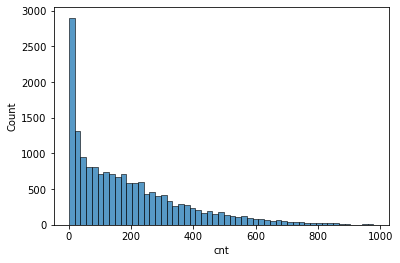

In [192]:
sns.histplot(x='cnt', data=bike_df);

The distribution is skewed.  This is notable, so lets keep this in the back of our minds.  But we can hold off on the alarm bells for now. Lets see what model performance looks like first.  

#### Train Test Split

In [193]:
y = bike_df['cnt']
bike_df.drop(columns=['cnt'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(bike_df, y, test_size=.33, random_state=1)

In [194]:
X_train.sample(3)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
3754,2,-1.005134,-0.156390,-0.512966,0,5,1,1,1.262073,1.198898,-0.244805,-0.456099
4020,3,-1.005134,-0.156390,-0.223706,0,2,1,2,0.742729,0.582064,1.051040,0.031899
5524,3,-1.005134,0.425229,-1.380744,0,2,1,1,0.327253,0.317291,-0.555808,0.031899


In [195]:
y_train.sample(3)

16345    210
2504      65
16095    275
Name: cnt, dtype: int64

## Linear Model

In [196]:
linear = LinearRegression().fit(X_train, y_train)
scores = cross_val_score(linear, X_train, y_train, cv=10)
mse = cross_val_score(linear, X_train, y_train, scoring='neg_mean_squared_error',cv=10)

#### R2

In [197]:
scores.mean()

0.38225433816479293

#### MSE

In [198]:
mse.mean()

-19914.730056064203

#### RMSE

In [199]:
np.sqrt(-mse.mean())

141.1195594383153

# Part 3
Going to use the original data to create the new test data.  

In [209]:
#Seem to have null problems when I was doing them all at once, todo:Look into that
bike_df = pd.concat([pd.get_dummies(bike_df['season'], prefix="season"),bike_df], axis=1)
bike_df = pd.concat([pd.get_dummies(bike_df['holiday'], prefix="holiday"), bike_df], axis=1)
bike_df = pd.concat([pd.get_dummies(bike_df['weekday'], prefix="weekday"), bike_df], axis=1)
bike_df = pd.concat([pd.get_dummies(bike_df['workingday'], prefix="workingday"), bike_df], axis=1)
bike_df = pd.concat([pd.get_dummies(bike_df['weathersit'], prefix="weathersit"), bike_df], axis=1)

In [211]:
bike_df.drop(columns=['season', 'holiday', 'weekday', 'workingday', 'weathersit'], inplace=True)

In [219]:
bike_df.sample(3)

,weathersit_1,weathersit_2,weathersit_3,weathersit_4,workingday_0,workingday_1,weekday_0,weekday_1,weekday_2,weekday_3,...,season_2,season_3,season_4,yr,mnth,hr,temp,atemp,hum,windspeed
842,0,1,0,0,0,1,0,1,0,0,...,0,0,0,-1.005134,-1.319628,0.210183,-0.711435,-0.652768,-0.296639,-0.821484
4693,1,0,0,0,0,1,0,0,1,0,...,0,1,0,-1.005134,0.134419,-0.079077,1.677548,1.904183,-0.192971,-1.553889
14939,1,0,0,0,0,1,0,0,0,1,...,0,1,0,0.994892,0.716038,0.644072,0.638860,0.846255,-1.436983,-1.553889


#### New Train Test Split

In [220]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(bike_df, y, test_size=.33, random_state=12)

In [221]:
linear2 = LinearRegression().fit(X_train2, y_train2)
scores2 = cross_val_score(linear2, X_train2, y_train2, cv=10)
mse2 = cross_val_score(linear2, X_train2, y_train2, scoring='neg_mean_squared_error',cv=10)

#### New R2

In [222]:
scores2.mean()

0.3951164659281761

#### New MSE



In [223]:
mse.mean()

-19914.730056064203

#### New RMSE

In [224]:
np.sqrt(-mse2.mean())

139.59578510077233

### Additional Models

In [250]:
table = PrettyTable()
table.field_names = ['Model', 'R2', 'MSE', 'RMSE']

In [236]:
mods = [DecisionTreeRegressor(random_state=0), 
        RandomForestRegressor(random_state=0,n_estimators=30),
       SGDRegressor(max_iter=1000, tol=1e-3),
       Lasso(alpha=.1),
       ElasticNet(random_state=0),
       Ridge(alpha=.5),
       BaggingRegressor()]

In [252]:
for mod in mods:
    #print(mod)
    mod.fit(X_train2, y_train2)
    y_hat = mod.predict(X_train2)
    mse = mean_squared_error(y_train2,y_hat)
    #print(mse)
    score = r2_score(y_train2, y_hat)
    rmse = np.sqrt(mse)
    table.add_row([type(mod).__name__, score, mse, rmse])
    
print(table)

+-----------------------+---------------------+--------------------+--------------------+
|         Model         |          R2         |        MSE         |        RMSE        |
+-----------------------+---------------------+--------------------+--------------------+
| DecisionTreeRegressor |  0.9999952620765911 | 0.1527527269604054 | 0.3908359335583224 |
| RandomForestRegressor |  0.990571383893309  | 303.98271509330965 | 17.435100088422484 |
|      SGDRegressor     |  0.3970730675503964 | 19438.62851716363  | 139.42248210802887 |
|         Lasso         | 0.39766456540385287 | 19419.558367161666 | 139.3540755312225  |
|       ElasticNet      |  0.3629657921791921 | 20538.262021641163 | 143.31176511941078 |
|         Ridge         |  0.3977074937591353 | 19418.17433817527  | 139.3491095708016  |
|    BaggingRegressor   |  0.9884920725884555 | 371.0206227587869  | 19.26189561696322  |
+-----------------------+---------------------+--------------------+--------------------+


Interesting results.  I guess this is one of those scenarios where Decision Tree actually beats Random Forrest.

# Part 4

In [253]:
best_models = [DecisionTreeRegressor(random_state=0), RandomForestRegressor(random_state=0,n_estimators=30),BaggingRegressor()]

In [270]:
p4_table = PrettyTable()
p4_table.field_names = ['Model', 'R2', 'MSE', 'RMSE']

In [271]:
for model in best_models:
    mse = cross_val_score(model, X_train2, y_train2, scoring='neg_mean_squared_error').mean()
    scores = cross_val_score(model,X_train2, y_train2, cv=10)
    r2 = scores.mean()
    #print(mse)
    rmse = np.sqrt(-mse)
    p4_table.add_row([type(model).__name__, r2, mse, rmse])
    
print(p4_table)

+-----------------------+--------------------+--------------------+-------------------+
|         Model         |         R2         |        MSE         |        RMSE       |
+-----------------------+--------------------+--------------------+-------------------+
| DecisionTreeRegressor | 0.880721659453406  | -4113.26333052805  | 64.13472796019369 |
| RandomForestRegressor | 0.936955459235375  | -2076.958478006491 | 45.57365991454374 |
|    BaggingRegressor   | 0.9328776806445749 | -2255.377154707886 | 47.49081126605321 |
+-----------------------+--------------------+--------------------+-------------------+


Random Forest Prevails once again.

### Randomize Search CV

In [273]:
boostrap = [True, False]
max_depth = [int(x) for x in np.linspace(10,110,11)]
max_features = ['auto', 'sqrt']
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
n_estimators = [int(x) for x in np.linspace(200,2000,10)]
forest = RandomForestRegressor(random_state=0)

In [281]:
grid = {
    'bootstrap': boostrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'n_estimators':n_estimators    
}

In [282]:
search = RandomizedSearchCV(estimator=forest, param_distributions=grid, n_iter=20, cv=3, n_jobs=-1 )
search.fit(X_train2, y_train2)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]})

In [283]:
print(search.best_estimator_)

RandomForestRegressor(max_depth=30, n_estimators=800, random_state=0)


In [284]:
print(search.best_params_)

{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}


### CV on Best Etimator

#### Best Model R2

In [291]:
#going to inherit 3 from above, cause this seems to be taking longer than the search did
r2 = cross_val_score(search.best_estimator_,X_train2, y_train2, cv=3).mean()

In [292]:
r2

0.9345696159843712

#### Best Model MSE

In [289]:
mse = cross_val_score(search.best_estimator_,X_train2, y_train2, cv=3, scoring='neg_mean_squared_error').mean()

In [290]:
mse

-2107.9313707898423

#### Best Model RMSE

In [295]:
rmse = np.sqrt(-mse)
rmse

45.912213743075405

Performance slightly declined, but its a negligable difference.  

### Test Aginst Test Set

In [296]:
testy_hat = search.best_estimator_.predict(X_test2)

#### Test R2

In [297]:
r2_score(y_test2, testy_hat)

0.9451025897659858

#### Test RMSE

In [299]:
mean_squared_error(y_test2, testy_hat, squared=False)

43.34851789080203

It appears the Random Forrest from the search may generalize decently.  The performance is slightly better against test.  